### Data Import


#### Note: Data Import codes only works in Google Colab

In [1]:
from google.cloud import bigquery
from google.colab import files
from datetime import datetime
from datetime import timedelta, date
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from fastai.basics import *
from IPython.core.pylabtools import figsize
import gc, json
from pandas.io.json import json_normalize
from datetime import datetime
import lightgbm as lgb
gc.enable()

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


### Importing data from Google Bigquery

In [0]:
# project_id = 'original-future-244717' #evelyn's account
project_id = 'sephora-analytics' #mengyong's account
#project_id = 'crack-solstice-246414' #mengyong2's account
#project_id = 'composite-fire-245303' #johnny's account
#project_id = 'test1-245216' #desmond's account

In [3]:
data = """

 SELECT 
    fullvisitorid,
    visitid,
    channelGrouping,
    parse_DATE("%E4Y%m%d",_table_suffix) AS date,
    ifnull(totals.visits,0) visits,
    ifnull(totals.hits,0) hits,
    ifnull(totals.pageviews,0) pageviews,
    ifnull(totals.timeOnSite,0) timeonsite,
    ifnull(totals.bounces,0) bounces,
    ifnull(totals.transactions,0) transactions,
    ifnull(totals.transactionRevenue,0) transactionrevenue,
    ifnull(totals.newVisits,0) newvisits,
    ifnull(totals.screenviews,0) screenviews,
    ifnull(totals.uniqueScreenviews,0) uniquescreenviews,
    ifnull(totals.timeOnScreen,0) timeonscreen,
    ifnull(totals.sessionQualityDim,0) sessionqualitydim,
    ifnull(trafficSource.referralPath,'') referralpath,
    ifnull(trafficSource.campaign,'') campaign,
    ifnull(trafficSource.source,'') source,
    ifnull(trafficSource.medium,'') medium,
    ifnull(trafficSource.keyword,'') keyword,
    ifnull(trafficSource.adContent,'') adcontent,    
    device.operatingSystem,
    device.isMobile,
    device.deviceCategory, 
  case when geoNetwork.networkDomain IN ('(not set)', 'not available in demo dataset', '(not provided)', 'unknown.unknown', '/', 'Not Socially Engaged') then '' else geoNetwork.networkDomain end networkDomain,
  case when geoNetwork.region IN ('(not set)', 'not available in demo dataset', '(not provided)', 'unknown.unknown', '/', 'Not Socially Engaged') then '' else geoNetwork.region end region,
  case when geoNetwork.metro IN ('(not set)', 'not available in demo dataset', '(not provided)', 'unknown.unknown', '/', 'Not Socially Engaged') then '' else geoNetwork.metro end metro,
  case when geoNetwork.country IN ('(not set)', 'not available in demo dataset', '(not provided)', 'unknown.unknown', '/', 'Not Socially Engaged') then '' else geoNetwork.country end country,
  case when geoNetwork.continent IN ('(not set)', 'not available in demo dataset', '(not provided)', 'unknown.unknown', '/', 'Not Socially Engaged') then '' else geoNetwork.continent end continent,
  case when geoNetwork.subcontinent IN ('(not set)', 'not available in demo dataset', '(not provided)', 'unknown.unknown', '/', 'Not Socially Engaged') then '' else geoNetwork.subcontinent end subcontinent,
  case when geoNetwork.city IN ('(not set)', 'not available in demo dataset', '(not provided)', 'unknown.unknown', '/', 'Not Socially Engaged') then '' else geoNetwork.city end city
    
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    parse_DATE("%E4Y%m%d", _table_suffix) BETWEEN '2016-11-01' AND '2017-07-30'
    and totals.hits > 1 

"""

data = pd.io.gbq.read_gbq(data,project_id=project_id,dialect='standard',verbose=False)
data.head(1)

/usr/local/lib/python3.6/dist-packages/pandas_gbq/gbq.py:810: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  "verbosity", FutureWarning, stacklevel=1)


,fullvisitorid,visitid,channelGrouping,date,visits,hits,pageviews,timeonsite,bounces,transactions,transactionrevenue,newvisits,screenviews,uniquescreenviews,timeonscreen,sessionqualitydim,referralpath,campaign,source,medium,keyword,adcontent,operatingSystem,isMobile,deviceCategory,networkDomain,region,metro,country,continent,subcontinent,city
0,664662482337384828,1491884471,Organic Search,2017-04-10,1,2,2,29,0,0,0,1,0,0,0,0,,(not set),google,organic,(not provided),,Android,True,tablet,,,,Peru,Americas,South America,


### Creating short-term and long-term data

In [0]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

start_dt = date(2017, 3, 1)
end_dt = date(2017, 6, 30)

In [5]:
#long term
long_term = pd.DataFrame()

for dt in daterange(start_dt, end_dt):
    start_cutoff = dt - timedelta(days=99)
    end_cutoff = dt - timedelta(days=9)
    #print(start_cutoff,end_cutoff)
    lt = data[(data['date'] >= start_cutoff) & (data['date'] <= end_cutoff)].groupby(['fullvisitorid'])['visits', 'hits', 'pageviews', 'timeonsite', 'bounces', 'transactions', 'transactionrevenue'].sum().reset_index()
    lt = lt.rename(columns={'visits': 'visits_lt', 'hits':'hits_lt', 'pageviews':'pageviews_lt', 'timeonsite': 'timeonsite_lt', 'bounces':'bounces_lt', 'transactions':'transactions_lt', 'transactionrevenue':'transactionrevenue_lt'})
    lt['date'] = dt      
    lt['date_lt_start'] = start_cutoff  
    lt['date_lt_end'] = end_cutoff  
    #print(lt.head(1))
    long_term = long_term.append(lt)

long_term.head()

,fullvisitorid,visits_lt,hits_lt,pageviews_lt,timeonsite_lt,bounces_lt,transactions_lt,transactionrevenue_lt,date,date_lt_start,date_lt_end
0,0000020424342248747,1,17,13,297,0,0,0,2017-03-01,2016-11-22,2017-02-20
1,0000027376579751715,1,6,5,49,0,0,0,2017-03-01,2016-11-22,2017-02-20
2,0000040862739425590,2,5,5,49,0,0,0,2017-03-01,2016-11-22,2017-02-20
3,0000388388833742701,1,2,2,6,0,0,0,2017-03-01,2016-11-22,2017-02-20
4,0000500012543476818,1,4,4,34,0,0,0,2017-03-01,2016-11-22,2017-02-20


In [6]:
#short term
short_term = pd.DataFrame()

for dt in daterange(start_dt, end_dt):
    start_cutoff = dt - timedelta(days=8)
    end_cutoff =  dt - timedelta(days=1)
    #print(start_cutoff,end_cutoff)
    st = data[(data['date'] >= start_cutoff) & (data['date'] <= end_cutoff)].groupby(['fullvisitorid'])['visits', 'hits', 'pageviews', 'timeonsite', 'bounces', 'transactions', 'transactionrevenue'].sum().reset_index()
    st = st.rename(columns={'visits': 'visits_st', 'hits':'hits_st', 'pageviews':'pageviews_st', 'timeonsite': 'timeonsite_st', 'bounces':'bounces_st', 'transactions':'transactions_st', 'transactionrevenue':'transactionrevenue_st'})
    st['date'] = dt  
    st['date_st_start'] = start_cutoff  
    st['date_st_end'] = end_cutoff  
    #print(st.head(1))
    short_term = short_term.append(st)

short_term.head()

,fullvisitorid,visits_st,hits_st,pageviews_st,timeonsite_st,bounces_st,transactions_st,transactionrevenue_st,date,date_st_start,date_st_end
0,0003466641382018027,1,3,3,33,0,0,0,2017-03-01,2017-02-21,2017-02-28
1,0005703676124397865,1,9,8,373,0,0,0,2017-03-01,2017-02-21,2017-02-28
2,0012894526858063685,1,2,2,21,0,0,0,2017-03-01,2017-02-21,2017-02-28
3,0015460355736675099,1,16,15,325,0,0,0,2017-03-01,2017-02-21,2017-02-28
4,0015950283479889703,2,33,29,1214,0,1,1500000,2017-03-01,2017-02-21,2017-02-28


In [7]:
#future transactions
target = pd.DataFrame()

for dt in daterange(start_dt, end_dt):
    start_cutoff = dt
    end_cutoff = dt + timedelta(days=7)
    #print(start_cutoff,end_cutoff)
    tar = data[(data['date'] >= start_cutoff) & (data['date'] <= end_cutoff)].groupby(['fullvisitorid'])['transactions', 'transactionrevenue'].sum().reset_index()
    tar = tar.rename(columns={'transactions':'transactions_target', 'transactionrevenue':'transactionrevenue_target'})
    tar['date'] = start_cutoff  
    tar['date_target_end'] = end_cutoff 
    #print(target.head(1))
    target = target.append(tar)
    
target['transactions_target'] = np.where(target['transactions_target']>0, 1, 0)
target.head()


,fullvisitorid,transactions_target,transactionrevenue_target,date,date_target_end
0,0002486496724246360,0,0,2017-03-01,2017-03-08
1,0003036496767745885,0,0,2017-03-01,2017-03-08
2,0004476868382641421,0,0,2017-03-01,2017-03-08
3,0005085643067443862,0,0,2017-03-01,2017-03-08
4,0005703676124397865,0,0,2017-03-01,2017-03-08


### Extracting Today data

In [8]:
today = """

WITH
  cleaned_data AS(
 SELECT
    fullvisitorid,
    visitid,
    channelGrouping,
    parse_DATE("%E4Y%m%d",_table_suffix) AS date,
    ifnull(totals.visits,0) visits,
    ifnull(totals.hits,0) hits,
    ifnull(totals.pageviews,0) pageviews,
    ifnull(totals.timeOnSite,0) timeOnSite,
    ifnull(totals.bounces,0) bounces,
    ifnull(totals.transactions,0) transactions,
    ifnull(totals.transactionRevenue,0) transactionRevenue,
    ifnull(totals.newVisits,0) newvisits,
    ifnull(totals.screenviews,0) screenviews,
    ifnull(totals.uniqueScreenviews,0) uniquescreenviews,
    ifnull(totals.timeOnScreen,0) timeonscreen,
    ifnull(totals.sessionQualityDim,0) sessionqualitydim,
    ifnull(trafficSource.referralPath,'') referralpath,
    ifnull(trafficSource.campaign,'') campaign,
    ifnull(trafficSource.source,'') source,
    ifnull(trafficSource.medium,'') medium,
    ifnull(trafficSource.keyword,'') keyword,
    ifnull(trafficSource.adContent,'') adcontent,    
    device.operatingSystem,
    device.isMobile,
    device.deviceCategory, 
  case when geoNetwork.networkDomain IN ('(not set)', 'not available in demo dataset', '(not provided)', 'unknown.unknown', '/', 'Not Socially Engaged') then '' else geoNetwork.networkDomain end networkDomain,
  case when geoNetwork.region IN ('(not set)', 'not available in demo dataset', '(not provided)', 'unknown.unknown', '/', 'Not Socially Engaged') then '' else geoNetwork.region end region,
  case when geoNetwork.metro IN ('(not set)', 'not available in demo dataset', '(not provided)', 'unknown.unknown', '/', 'Not Socially Engaged') then '' else geoNetwork.metro end metro,
  case when geoNetwork.country IN ('(not set)', 'not available in demo dataset', '(not provided)', 'unknown.unknown', '/', 'Not Socially Engaged') then '' else geoNetwork.country end country,
  case when geoNetwork.continent IN ('(not set)', 'not available in demo dataset', '(not provided)', 'unknown.unknown', '/', 'Not Socially Engaged') then '' else geoNetwork.continent end continent,
  case when geoNetwork.subcontinent IN ('(not set)', 'not available in demo dataset', '(not provided)', 'unknown.unknown', '/', 'Not Socially Engaged') then '' else geoNetwork.subcontinent end subcontinent,
  case when geoNetwork.city IN ('(not set)', 'not available in demo dataset', '(not provided)', 'unknown.unknown', '/', 'Not Socially Engaged') then '' else geoNetwork.city end city
    
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    parse_DATE("%E4Y%m%d", _table_suffix) BETWEEN '2017-03-01' AND '2017-06-30'
    and totals.hits > 1 
    -- July 2 and 3 as today
    -- July 2 and 3 as today
    )
  
  SELECT
    fullvisitorid,
    date,
    max(channelgrouping) as channelgrouping,
    COUNT(DISTINCT visitid) AS sessions,
    SUM(hits) AS hits_today,
    SUM(pageviews) AS pageviews_today,
    SUM(timeonSite) AS timeonsite_today,
    SUM(bounces) AS bounces_today,
   -- SUM(transactions) AS transaction_today,
   -- SUM(transactionRevenue) AS transaction_revenue_today,
    sum(newvisits) as newvisits_today,
    sum(uniquescreenviews) as uniquescreenviews_today,
    sum(timeonscreen) as timeonscreen_today,
    avg(sessionqualitydim) as sessionqualitydim_today,
    max(campaign) as campaign_today,
    max(source) as source_today,
    max(medium) as medium_today,
    max(keyword) as keyword_today,
    max(adcontent) as adcontent_today,
    max(operatingsystem) as operatingsystem,
    max(ismobile) as ismobile,
    max(deviceCategory) as devicecategory,
    max(continent) as continent,
    max(subcontinent) as subcontinent,
    max(country) as country,
    max(metro) as metro,
    max(city) as city

  FROM
    cleaned_data

  GROUP BY
    1,
    2 

"""

today = pd.io.gbq.read_gbq(today,project_id=project_id,dialect='standard',verbose=False)
today.head(1)

/usr/local/lib/python3.6/dist-packages/pandas_gbq/gbq.py:810: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  "verbosity", FutureWarning, stacklevel=1)


,fullvisitorid,date,channelgrouping,sessions,hits_today,pageviews_today,timeonsite_today,bounces_today,newvisits_today,uniquescreenviews_today,timeonscreen_today,sessionqualitydim_today,campaign_today,source_today,medium_today,keyword_today,adcontent_today,operatingsystem,ismobile,devicecategory,continent,subcontinent,country,metro,city
0,1049239169611007851,2017-06-03,Direct,1,2,2,6,0,1,0,0,0.0,(not set),(direct),(none),,,Macintosh,False,desktop,Americas,Northern America,United States,,


### Joining them all together

In [9]:
combined_process1 = pd.merge(today, short_term, how='left', on = ['fullvisitorid', 'date'])
combined_process2 = pd.merge(combined_process1, long_term, how='left', on = ['fullvisitorid', 'date'])
combined_final = pd.merge(combined_process2, target, how='left', on = ['fullvisitorid', 'date'])

combined_final.head()

,fullvisitorid,date,channelgrouping,sessions,hits_today,pageviews_today,timeonsite_today,bounces_today,newvisits_today,uniquescreenviews_today,timeonscreen_today,sessionqualitydim_today,campaign_today,source_today,medium_today,keyword_today,adcontent_today,operatingsystem,ismobile,devicecategory,continent,subcontinent,country,metro,city,visits_st,hits_st,pageviews_st,timeonsite_st,bounces_st,transactions_st,transactionrevenue_st,date_st_start,date_st_end,visits_lt,hits_lt,pageviews_lt,timeonsite_lt,bounces_lt,transactions_lt,transactionrevenue_lt,date_lt_start,date_lt_end,transactions_target,transactionrevenue_target,date_target_end
0,1049239169611007851,2017-06-03,Direct,1,2,2,6,0,1,0,0,0.0,(not set),(direct),(none),,,Macintosh,False,desktop,Americas,Northern America,United States,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,2017-06-10
1,4567008821344687983,2017-06-03,Organic Search,1,2,2,84,0,0,0,0,0.0,(not set),google,organic,(not provided),,Windows,False,desktop,Americas,South America,Peru,,La Victoria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,2017-06-10
2,3035118591091443775,2017-06-03,Organic Search,1,2,2,8,0,1,0,0,0.0,(not set),google,organic,(not provided),,iOS,True,mobile,Asia,Southeast Asia,Singapore,,Singapore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,2017-06-10
3,1719046824305285616,2017-06-03,Organic Search,1,2,2,21,0,1,0,0,0.0,(not set),yahoo,organic,(not provided),,iOS,True,tablet,Americas,Northern America,United States,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,2017-06-10
4,2270273496342331509,2017-06-03,Organic Search,1,2,2,37,0,1,0,0,0.0,(not set),google,organic,(not provided),,Windows,False,desktop,Asia,Southern Asia,India,,Bengaluru,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,2017-06-10


In [0]:
#combined_final=combined_final.drop(['Unnamed: 0'], axis=1)
combined_final=combined_final.dropna(how='all')
combined_final=combined_final.fillna(0)

In [11]:
'''for col in combined_final:
    if combined_final[col].name!='fullvisitorid':
        print('=' * 48)
        print('name:', combined_final[col].name)
        print('dtype:', combined_final[col].dtype)
        print('-' * 48)
        print(combined_final[col].value_counts(dropna=False))'''

"for col in combined_final:\n    if combined_final[col].name!='fullvisitorid':\n        print('=' * 48)\n        print('name:', combined_final[col].name)\n        print('dtype:', combined_final[col].dtype)\n        print('-' * 48)\n        print(combined_final[col].value_counts(dropna=False))"

In [0]:
num_row=len(combined_final)
operating_system=np.empty(num_row, dtype = object)
source=np.empty(num_row, dtype = object)
last_visit_month=np.zeros(num_row)


for i in range(num_row):
    if combined_final.iloc[i]['operatingsystem'] in ['Windows','Macintosh','Android','iOS','Linux','Chrome OS']:
        operating_system[i]=combined_final.iloc[i]['operatingsystem']
    else:
        operating_system[i]='others'
    

    if combined_final.iloc[i]['source_today']=='(direct)':
        source[i]='direct'
    elif combined_final.loc[i]['source_today']=='Partners':
        source[i]='partners'
    elif str(combined_final.iloc[i]['source_today']).find('youtube')>=0:
        source[i]='youtube'
    elif str(combined_final.iloc[i]['source_today']).find('google')>=0:
        source[i]='google'
    elif str(combined_final.iloc[i]['source_today']).find('facebook')>=0:
        source[i]='facebook'
    else:
        source[i]='others' 

In [13]:
combined_final=combined_final.drop(['source_today', 'operatingsystem', 'date_st_start', 'date_st_end', 'date_lt_start', 'date_lt_end', 'date_target_end', 'uniquescreenviews_today','timeonscreen_today','sessionqualitydim_today'],axis=1)

combined_final['operatingsystem']=operating_system.tolist()
combined_final['source_today']=source.tolist()
combined_final.head()

,fullvisitorid,date,channelgrouping,sessions,hits_today,pageviews_today,timeonsite_today,bounces_today,newvisits_today,campaign_today,medium_today,keyword_today,adcontent_today,ismobile,devicecategory,continent,subcontinent,country,metro,city,visits_st,hits_st,pageviews_st,timeonsite_st,bounces_st,transactions_st,transactionrevenue_st,visits_lt,hits_lt,pageviews_lt,timeonsite_lt,bounces_lt,transactions_lt,transactionrevenue_lt,transactions_target,transactionrevenue_target,operatingsystem,source_today
0,1049239169611007851,2017-06-03,Direct,1,2,2,6,0,1,(not set),(none),,,False,desktop,Americas,Northern America,United States,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,Macintosh,direct
1,4567008821344687983,2017-06-03,Organic Search,1,2,2,84,0,0,(not set),organic,(not provided),,False,desktop,Americas,South America,Peru,,La Victoria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,Windows,google
2,3035118591091443775,2017-06-03,Organic Search,1,2,2,8,0,1,(not set),organic,(not provided),,True,mobile,Asia,Southeast Asia,Singapore,,Singapore,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,iOS,google
3,1719046824305285616,2017-06-03,Organic Search,1,2,2,21,0,1,(not set),organic,(not provided),,True,tablet,Americas,Northern America,United States,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,iOS,others
4,2270273496342331509,2017-06-03,Organic Search,1,2,2,37,0,1,(not set),organic,(not provided),,False,desktop,Asia,Southern Asia,India,,Bengaluru,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,Windows,google


In [0]:
train_validation_dataset = combined_final[combined_final['date'] < date(2017, 6, 1)]
test_dataset = combined_final[combined_final['date'] >= date(2017, 6, 1)]

### Download Files Here

In [0]:
from google.colab import files
#train_validation_dataset.to_csv('train_validation_dataset.csv') 
#files.download('train_validation_dataset.csv')

In [0]:
#test_dataset.to_csv('test_dataset.csv') 
#files.download('test_dataset.csv')

### Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')

In [2]:
dataset = pd.read_csv('train_validation_dataset.csv')
dataset = dataset.drop(['Unnamed: 0','fullvisitorid', 'date', 'transactionrevenue_target', 'bounces_today', 'newvisits_today', 'bounces_lt', 'bounces_st'], axis = 1)

dataset.head(1)

,channelgrouping,sessions,hits_today,pageviews_today,timeonsite_today,campaign_today,medium_today,keyword_today,adcontent_today,ismobile,...,transactionrevenue_st,visits_lt,hits_lt,pageviews_lt,timeonsite_lt,transactions_lt,transactionrevenue_lt,transactions_target,operatingsystem,source_today
0,Organic Search,1,13,11,280,(not set),organic,(not provided),NaN,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Macintosh,google


In [6]:
class style:
    BOLD = '\033[1m'
    END = '\033[0m'

print(style.BOLD + 'Missing Values (%)' + style.END)
# show % dataset the cols with missing values.
print((dataset.isnull().sum()*100/len(dataset)).round(2).sort_values(ascending=False))
print('\n\n')
print(style.BOLD + 'Missing Values (Qty)' + style.END)
# show qty of all the cols with missing values.
print(dataset.isnull().sum().sort_values(ascending=False))
# .sort_values('percent_missing', inplace=True) #method to sort values.

Missing Values (%)
adcontent_today          97.83
metro                    71.44
city                     57.07
keyword_today            49.65
continent                 0.09
subcontinent              0.09
country                   0.09
sessions                  0.00
hits_today                0.00
pageviews_today           0.00
timeonsite_today          0.00
campaign_today            0.00
medium_today              0.00
ismobile                  0.00
devicecategory            0.00
source_today              0.00
operatingsystem           0.00
visits_st                 0.00
hits_st                   0.00
pageviews_st              0.00
timeonsite_st             0.00
transactions_st           0.00
transactionrevenue_st     0.00
visits_lt                 0.00
hits_lt                   0.00
pageviews_lt              0.00
timeonsite_lt             0.00
transactions_lt           0.00
transactionrevenue_lt     0.00
transactions_target       0.00
channelgrouping           0.00
dtype: float64



Mi

In [8]:
# Function to check range of value in a col.
def value_range(col):
    max = dataset[col].max()
    min = dataset[col].min()
    return max-min

numerical_data = dataset.select_dtypes(include=[float, int]).columns
value_range(numerical_data).apply(lambda x: format(x, 'f'))

visits_st                         24.000000
hits_st                          799.000000
pageviews_st                     601.000000
timeonsite_st                  28518.000000
transactions_st                   21.000000
transactionrevenue_st    32978660000.000000
visits_lt                         93.000000
hits_lt                         3118.000000
pageviews_lt                    2578.000000
timeonsite_lt                 130987.000000
transactions_lt                   25.000000
transactionrevenue_lt    68797350000.000000
dtype: object

In [3]:
dataset.describe()

,sessions,hits_today,pageviews_today,timeonsite_today,visits_st,hits_st,pageviews_st,timeonsite_st,transactions_st,transactionrevenue_st,visits_lt,hits_lt,pageviews_lt,timeonsite_lt,transactions_lt,transactionrevenue_lt,transactions_target
count,94892.000000,94892.000000,94892.000000,94892.000000,94892.000000,94892.000000,94892.000000,94892.000000,94892.000000,9.489200e+04,94892.000000,94892.000000,94892.000000,94892.000000,94892.000000,9.489200e+04,94892.000000
mean,1.071407,8.306475,6.917643,302.989167,0.150540,1.874067,1.498324,74.786515,0.010222,2.572767e+06,0.332072,4.367871,3.526293,179.452641,0.024533,2.374312e+07,0.038886
std,0.306635,12.618105,9.372483,556.670400,0.691624,13.036909,10.177499,558.110873,0.146338,1.820985e+08,2.606578,53.124663,43.242279,2438.162394,0.399160,1.027640e+09,0.193325
min,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,1.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
50%,1.000000,4.000000,4.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
75%,1.000000,9.000000,8.000000,310.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
max,8.000000,558.000000,466.000000,16891.000000,24.000000,799.000000,601.000000,28518.000000,21.000000,3.297866e+10,93.000000,3118.000000,2578.000000,130987.000000,25.000000,6.879735e+10,1.000000


0    91202
1     3690
Name: transactions_target, dtype: int64
Positives =  3.9 %


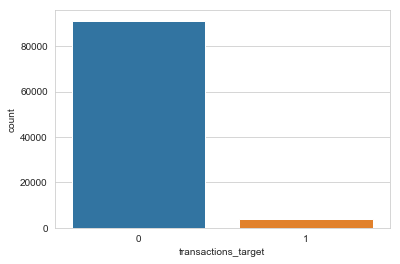

In [4]:
sns.countplot(x='transactions_target',data=dataset)
print(dataset['transactions_target'].value_counts())
print('Positives = ', round(dataset['transactions_target'].value_counts()[1]/dataset['transactions_target'].count(),3)*100, '%')

Data looks skewed to the left, with the bulk of activity metrics such as sessions, hits_today, pageviews_today having a small value, with outliers to the right

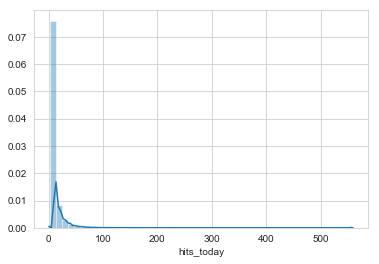

In [5]:
sns.distplot(dataset['hits_today'])

**Pair Plot**

The dataset can be observed through 3 lenses:
1. Today
Today data refers to the online activities on the observed day
2. Short Term
Short term data refers to the online activities 1 to 7 days before the observed day
3. Long Term
Short term data refers to the online activities 8 to 98 days before the observed day

EDA for Today variables


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


<Figure size 1152x1152 with 0 Axes>

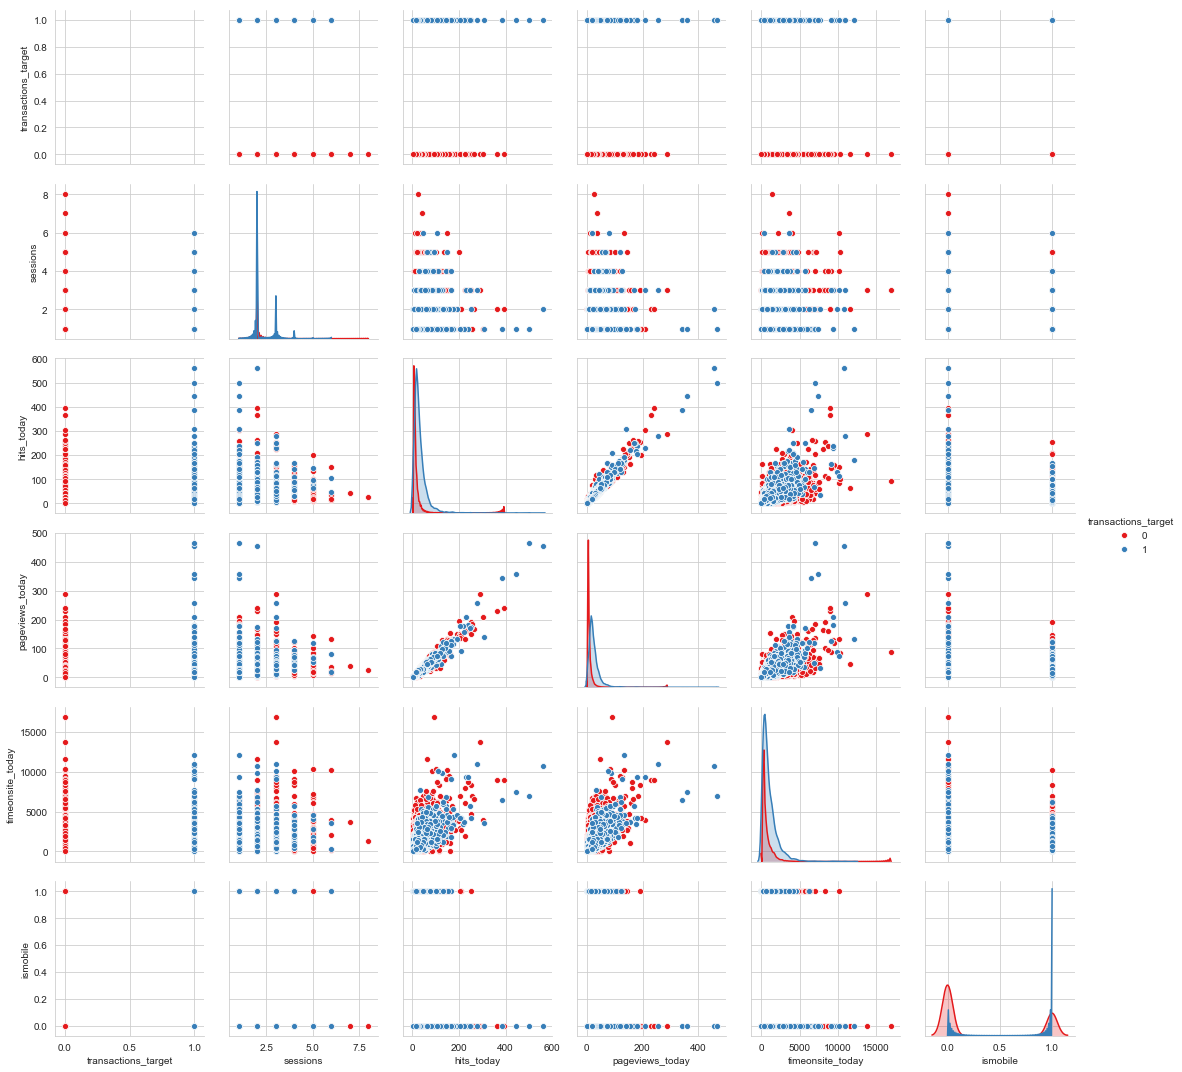

In [6]:
print('EDA for Today variables')
fig2 = plt.figure(figsize=(16,16))
sns.pairplot(dataset.iloc[:,np.hstack(([28],range(1,10)))],diag_kind='kde',hue='transactions_target',palette='Set1')

**Today data**

Blue dots represents purchase, and red dots represents no purchase<br>
Today data is as expected, high sessions, hits, pageview looks correlated to transaction<br>
Hits, pageview, and timeonsite data is highly correlated, which is expected

EDA for Short Term variables


<Figure size 1152x1152 with 0 Axes>

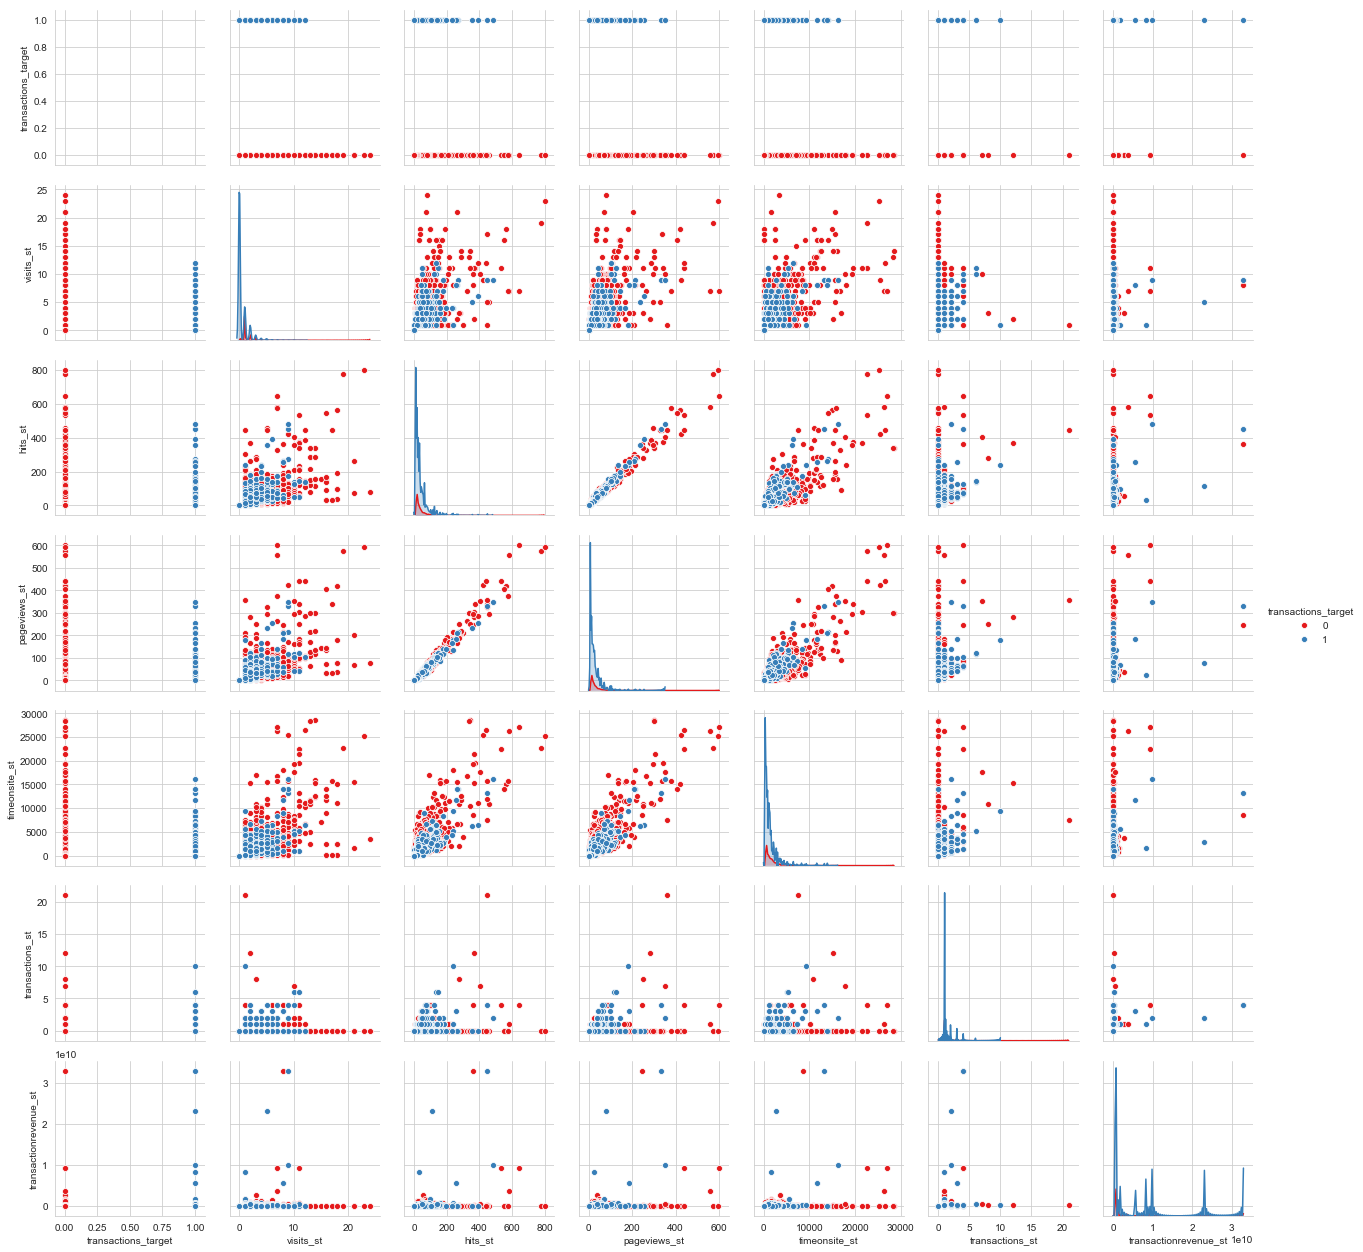

In [7]:
print('EDA for Short Term variables')
fig2 = plt.figure(figsize=(16,16));
sns.pairplot(dataset.iloc[:,np.hstack(([28],range(10,22)))],diag_kind='kde',hue='transactions_target',palette='Set1');

**Short Term data**

Blue dots represents purchase, and red dots represents no purchase<br>
Short term data is interesting, a very high visits, hits, page actually have a lower chance of transaction

EDA for Long Term variables


<Figure size 1152x1152 with 0 Axes>

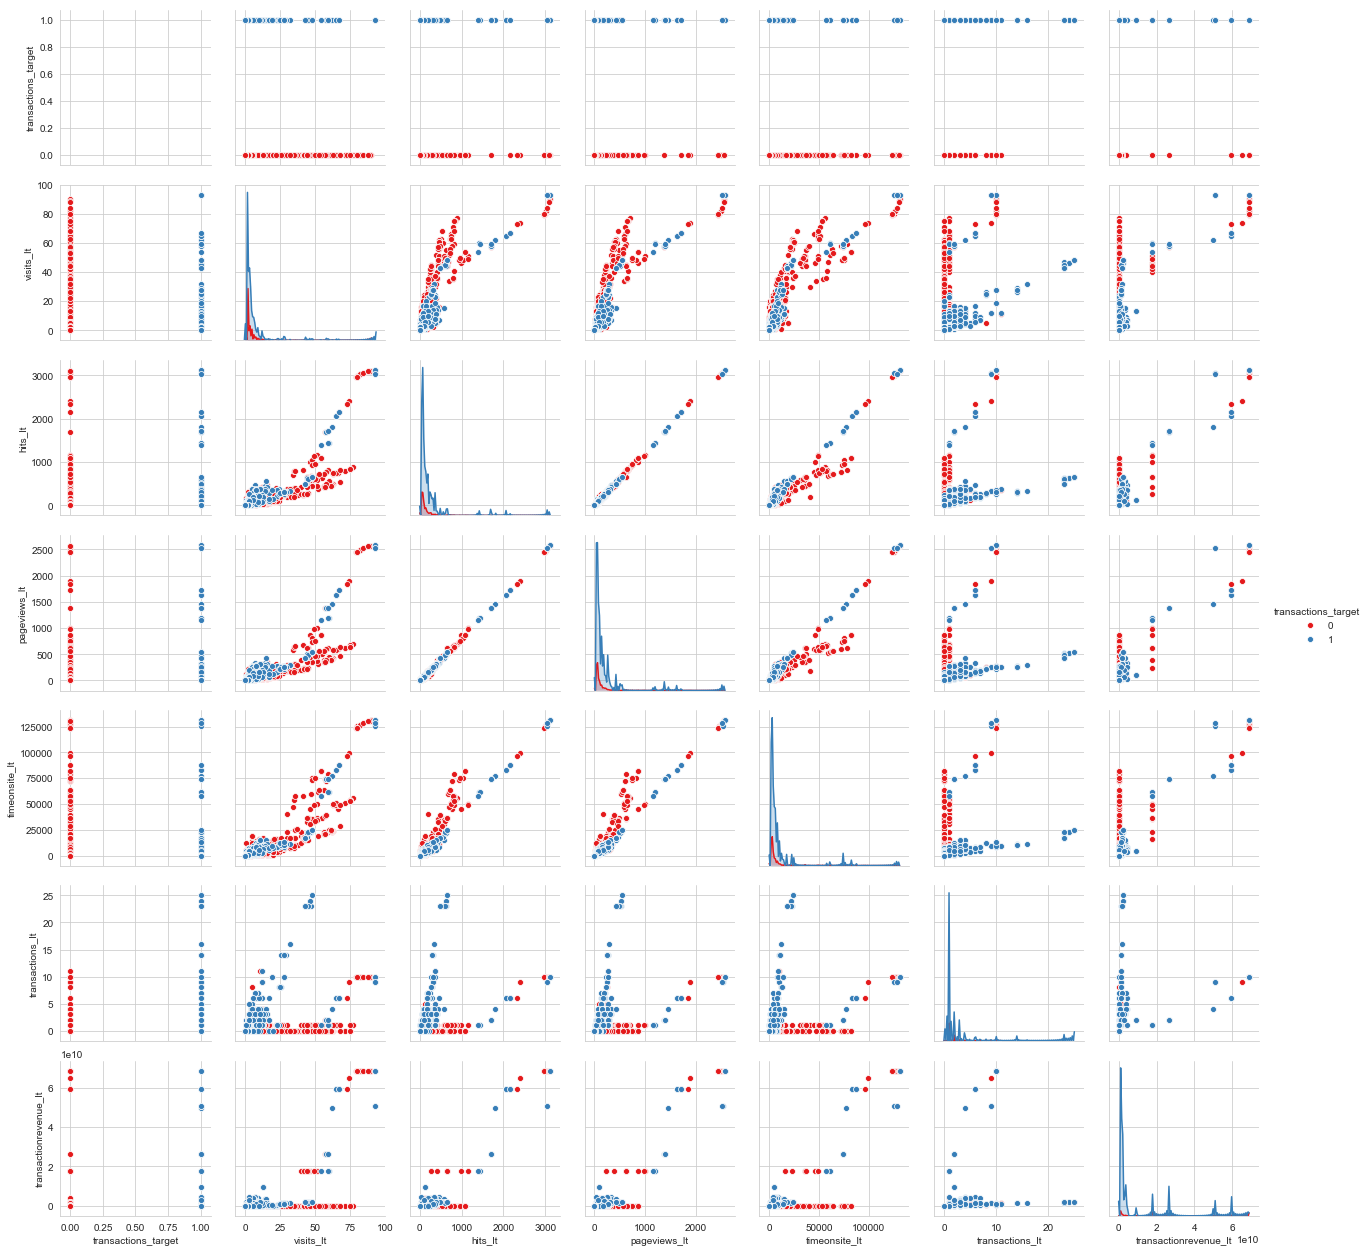

In [8]:
print('EDA for Long Term variables')
fig3 = plt.figure(figsize=(16,16));
sns.pairplot(dataset.iloc[:,np.hstack(([28],range(22,28)))],diag_kind='kde',hue='transactions_target',palette='Set1');

**Long Term data**

Blue dots represents purchase, and red dots represents no purchase<br>
Long term data is also very interesting, there seem to be distinct clusters of transactions and no transactions, rather than the points mixed together. It could indicate difference in web browsing behaviour of people purely browsing, and people with intention to purchase

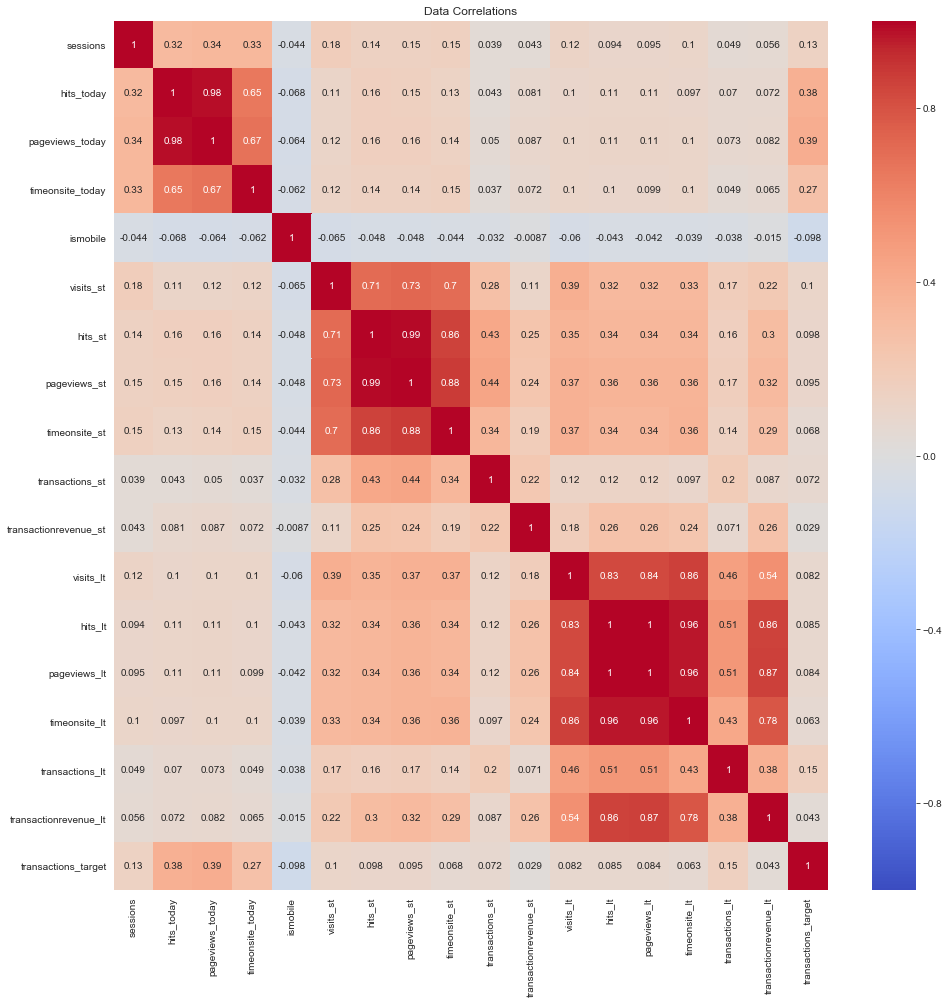

In [9]:
fig1 = plt.figure(figsize=(16,16));
dataset.corr()
plt.title('Data Correlations')
sns.heatmap(dataset.corr(), vmin = -1, vmax = 1, cmap = 'coolwarm', annot=True)

**Correlation Chart**

Today from today seems the most relevant towards transaction. <br>
Short term and long term data seems to also play a role in transaction, especially transactions long term and short term visits/hits/pageviews

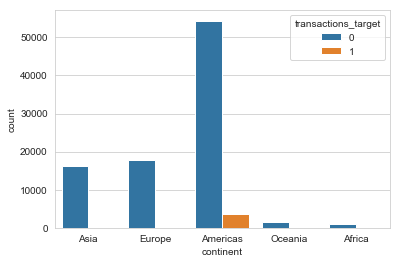

In [10]:
sns.countplot(x='continent', hue = 'transactions_target', data=dataset)

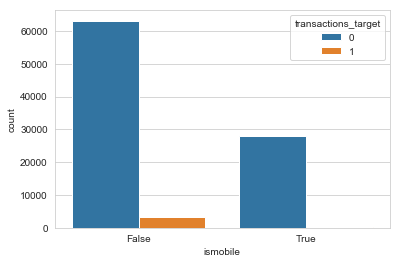

In [11]:
sns.countplot(x='ismobile', hue = 'transactions_target', data=dataset)

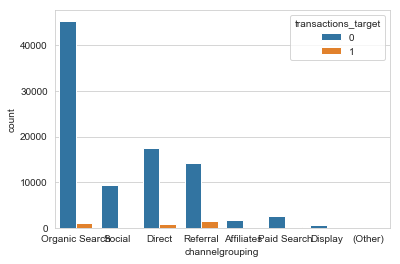

In [12]:
sns.countplot(x='channelgrouping', hue = 'transactions_target', data=dataset)

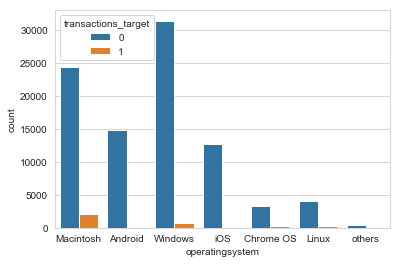

In [13]:
sns.countplot(x='operatingsystem', hue = 'transactions_target', data=dataset)

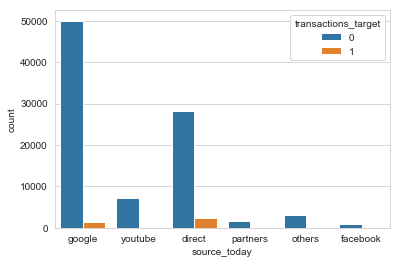

In [14]:
sns.countplot(x='source_today', hue = 'transactions_target', data=dataset)

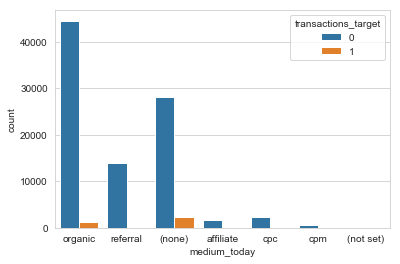

In [15]:
sns.countplot(x='medium_today', hue = 'transactions_target', data=dataset)

**Categorical Variables**

We can see distinct difference in transaction probability from different categorical features<br>
1. Continent - Most transactions originate from America
2. ismobile - Most transactions are from desktop
3. Channelgrouping - Organic search, direct and referral have a higher conversion
4. Operating System -Macintosh and windows seem to have a higher conversion. (I thought Mac users would not support google...)
5. Source - Direct and Google have higher conversion
6. Medium - Organic and (none) have higher conversion